In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [86]:
filename = "Feb12_Amp147mV_st025us.txt_dig2-usb22575_CH1_20240212123313-11.txt"
file = open(filename, "r")
length = len(file.readlines())
file.close()

#### SNR using peak height histogram

In [91]:
# Doing SNR using the peak noise method
peaks = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        peak = max(data)
        peaks.append(peak)
    else:
        pass

peaks = np.array(peaks)
print(len(peaks))

79


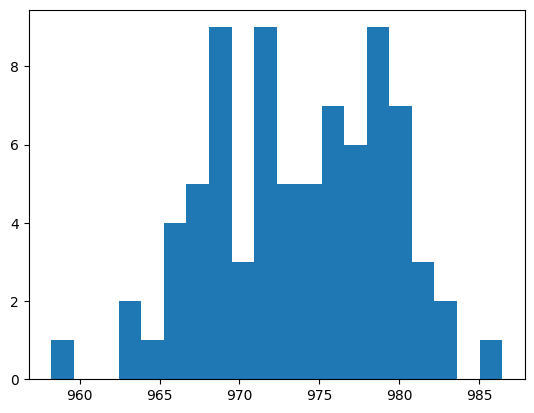

In [88]:
val = 20
n, b, p = plt.hist(peaks, bins=val)

In [82]:
from scipy.optimize import curve_fit
def Gauss(x, A, mean, std):
  gauss = A*np.exp(-(x-mean)**2/(2*std**2))
  return gauss

In [89]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[10, 970, 10])
print(popt)

[  7.31229186 973.38197713   6.43469772]


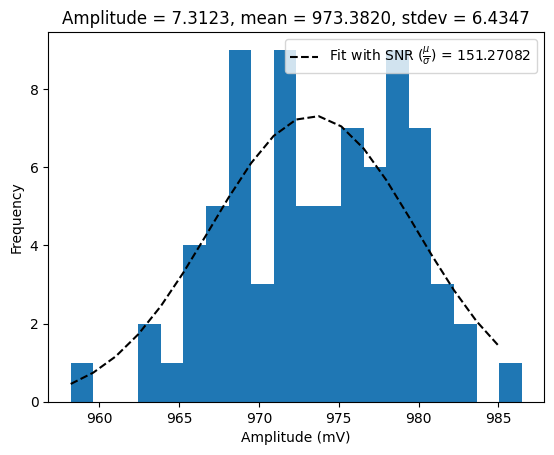

In [90]:
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black", label=r"Fit with SNR ($\frac{\mu}{\sigma}$) = %.05f" % (popt[1]/popt[2]))
n2, b2, p2 = plt.hist(peaks, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Result logs for peak height SNR method:
1. SNR for input amplitude 68 mV and gain by shaper is 115.35387 with 20 bins and Gaussian fit.
2. SNR for input amplitude 68 mV is 81.19303 with 20 bins and Gaussian fit (base case).
3. SNR for input ampltude 147 mV is 151.27082 with 20 bins and Gaussian fit.

This seems to suggest that the bulk of the noise is coming from somewhere in between the function generator and the shaper. This is where the best improvement was seen: 81 $\rightarrow$ 151 

There seems to be some improvement when the shaper gain is increased. This could mean that some noise was picked up downstream of the shaper; thus, the result after adjusting shaper gain is a bit better. 

However, this is a *very, very* rough calculation with only about ~79-80 (1 min data collection) samples for each case. 

#### SNR using each trace

Just talked to Tsuguo about this method and we're not going to pursue this anymore since this method has less statistics than the previous one.

#### How to proceed

We've narrowed down the problem to in between the function generator and the shaper. Now I'm going to go downstream and change the stage-2 gain, ie the gain on the second op-amp.

The idea is that we make the gain higher and then observe the SNR. To this end, we swapped out the 2k resistor for a 5k one. Now, the second stage gain is (1 + $\frac{5000}{255}$ ~ 20.60)

In [117]:
filename = "Feb12_Amp68mV_st025us_2ndstagebaseline.txt_dig2-usb22575_CH1_20240212144230-20.txt"
file = open(filename, "r")
length = len(file.readlines())
file.close()

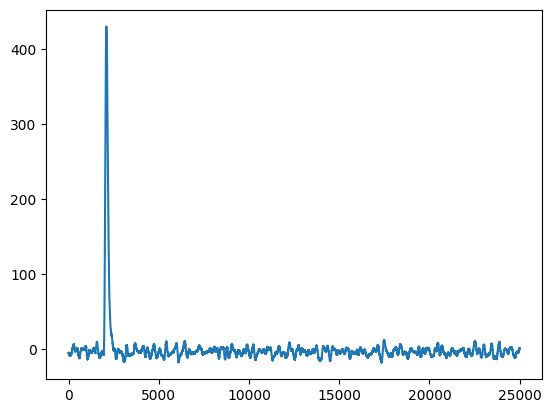

In [118]:
data = np.loadtxt(filename, skiprows=4, max_rows=1)
plt.plot(data)

In [119]:
# Doing SNR using the peak noise method
peaks = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        peak = max(data)
        peaks.append(peak)
    else:
        pass

peaks = np.array(peaks)
print(len(peaks))

79


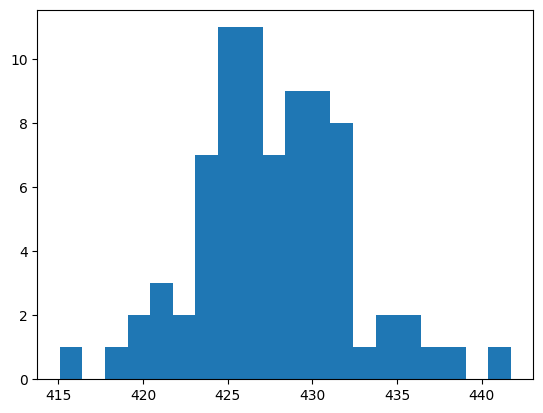

In [120]:
val = 20
n, b, p = plt.hist(peaks, bins=val)

In [122]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[16, 430, 10])
print(popt)

[ 10.22780985 426.77815099   3.98224217]


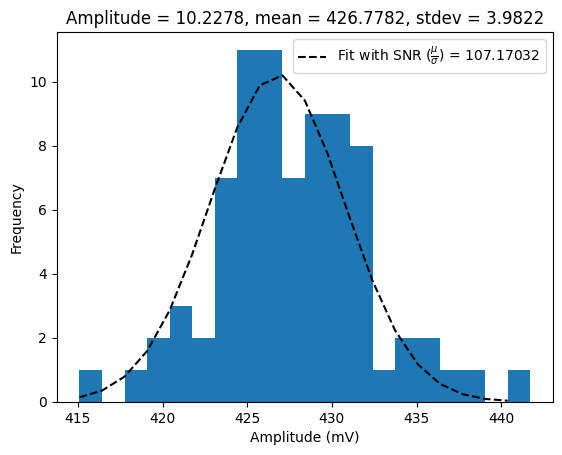

In [123]:
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black", label=r"Fit with SNR ($\frac{\mu}{\sigma}$) = %.05f" % (popt[1]/popt[2]))
n2, b2, p2 = plt.hist(peaks, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Result logs for changing second stage gain

All results below are with # of bins = 20.

1. Baseline SNR is 107.17046 for R1 = 2000 $\Omega$ (offset 50%). 
2. SNR with R1 = 5000 $\Omega$ (offset = 43%) is 84.89963.

So the SNR got worse when we amplified the second stage gain. I also visually confirmed that the noise got amplified after the gain was increased; this indicates that the noise occurs *BEFORE* the second stage gain as well. 

Image here:
![here](IMG_5680.JPG)

The yellow cursors above show the average peak-to-peak noise level when we had the higher gain on. Once we reinstalled the 2000 $\Omega$ resistor, we see that the amplitude of the noise has also gone back down. This makes it very clear that the noise occured before the second stage gain. 